In [1]:
import sys
sys.path.insert(0, "scripts")

start = datetime.date(2021, 1, 1)
end = datetime.date(2021, 2,1)
lb = load_bars(start, end, 1)
lb.tail()

ModuleNotFoundError: 'pyarrow.parquet' is required when using `read_parquet(..., use_pyarrow=True)`.
Please install using the command `pip install pyarrow`.

In [2]:
from pathlib import Path
import re

path = Path("~/workspace/zillionare/max-dama.srt").expanduser()
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

timestamps = ["00:00:00.000"]
for i in range(len(lines)):
    if re.match(r"^\d+:\d+", lines[i]):
        time = lines[i].split(":")
        mm = int(time[0])
        ss = int(time[1])
        timestamps.append(f"00:{mm:02d}:{ss:02d}.000")

timestamps.append("00:54:55,000")

print(len(lines), len(timestamps))
j = 0
m = 0
buffers = []
for i in range(len(lines)):
    line = lines[i]
    if re.match(r"^\d+:\d+", line):
        j += 1
        buffers.append(f"\n{j}\n")
        line = timestamps[j] + " --> " + timestamps[j+1] + "\n"
        buffers.append(line)
        continue
    
    buffers.append(line)
    if len(buffers) > 100:
        m += 1
        to = path.parent / f"srt/{m:02d}.srt"
        with open(to, "w", encoding="utf-8") as f:
            f.writelines(buffers)
            buffers = []

to = path.parent / f"srt/{m:02d}.srt"
if len(buffers) > 0:
    with open(to, "w", encoding="utf-8") as f:
        f.writelines(buffers)

1085 541


In [4]:
from pathlib import Path
buffers = []
for i in range(1, 17):
    print(f"processing {i:02d}")
    file = Path(f"~/workspace/zillionare/srt/{i:02d}-translated.srt").expanduser()
    with open(file, "r", encoding="utf-8") as f:
        buffers.extend(f.readlines())

to = Path("~/workspace/zillionare/srt/translated.srt").expanduser()
    
with open(to, "w", encoding="utf-8") as f:
    f.writelines(buffers)

processing 01
processing 02
processing 03
processing 04
processing 05
processing 06
processing 07
processing 08
processing 09
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16


In [2]:
lbt = load_bars_tushare(start, end, ["000001.XSHE"])
lbt.tail()

,,open,high,low,close,volume,amount,price
date,asset,,,,,,,
1970-01-01 05:36:50.126,000001.XSHE,22.30,23.32,22.30,22.37,1126720.55,2558575.511,22.31
1970-01-01 05:36:50.127,000001.XSHE,22.31,23.47,22.31,23.08,1294152.72,2976800.955,22.78
1970-01-01 05:36:50.128,000001.XSHE,22.78,23.18,22.45,22.81,857476.96,1948881.146,22.81
1970-01-01 05:36:50.129,000001.XSHE,22.81,23.54,22.71,23.09,1240258.41,2864101.419,23.00
1970-01-01 05:36:50.201,000001.XSHE,23.00,24.99,22.70,24.55,1475239.30,3529556.986,NaN


In [ ]:
import pandas as pd
import datetime

def _get_trade_dates(self, start: datetime.date, end: datetime.date) -> list[datetime.date]:
    """获取指定日期范围内的交易日"""
    dates = pd.bdate_range(start, end)
    return dates.date.tolist()

start = datetime.date(2025, 9, 30)
end = datetime.date(2025, 10, 9)

_get_trade_dates(start, end)

[datetime.date(2025, 9, 30),
 datetime.date(2025, 10, 1),
 datetime.date(2025, 10, 2),
 datetime.date(2025, 10, 3),
 datetime.date(2025, 10, 6),
 datetime.date(2025, 10, 7),
 datetime.date(2025, 10, 8),
 datetime.date(2025, 10, 9)]

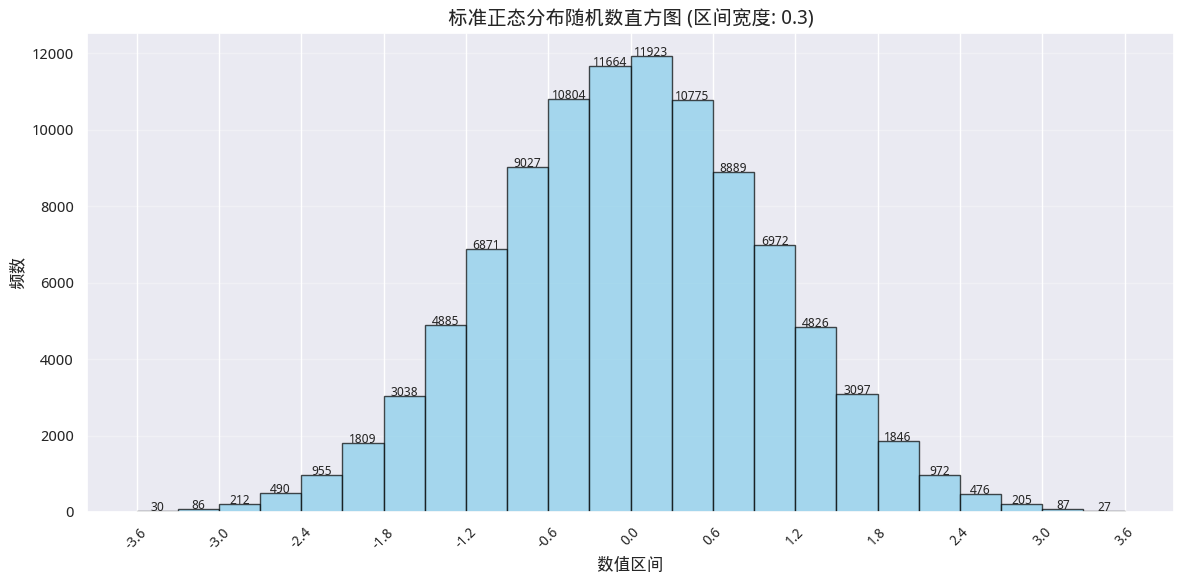

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 设置中文显示
plt.rcParams["font.family"] = ["WenQuanYi Micro Hei"]
plt.rcParams["axes.unicode_minus"] = False  # 正确显示负号

def plot_normal_histogram(sample_size=100, bin_width=0.3, x_range=(-3.6, 3.6), 
                          seed=42, show_counts=True):
    """
    绘制标准正态分布随机样本的直方图
    
    参数:
    sample_size: 样本数量
    bin_width: 区间宽度
    x_range: 元组，指定x轴范围 (start, end)
    seed: 随机种子，用于结果复现
    show_counts: 是否在柱子上方显示频数
    """
    # 生成标准正态分布随机数
    np.random.seed(seed)
    X = norm.rvs(size=sample_size)
    
    # 生成区间分割点
    start, end = x_range
    bins = np.arange(start, end + bin_width, bin_width)
    
    # 创建画布
    plt.figure(figsize=(12, 6))
    
    # 绘制直方图
    n, bins, patches = plt.hist(
        X, 
        bins=bins, 
        edgecolor='black', 
        alpha=0.7, 
        color='skyblue'
    )
    
    # 添加标题和标签
    plt.title(f'标准正态分布随机数直方图 (区间宽度: {bin_width})', fontsize=14)
    plt.xlabel('数值区间', fontsize=12)
    plt.ylabel('频数', fontsize=12)
    
    # 设置x轴刻度
    # 为避免刻度过于密集，根据区间宽度动态调整显示间隔
    tick_interval = 1 if bin_width >= 0.5 else 2 if bin_width >= 0.2 else 3
    plt.xticks(bins[::tick_interval], rotation=45, fontsize=10)
    
    # 添加网格线
    plt.grid(axis='y', alpha=0.3)
    
    # 在每个柱子上方显示频数
    if show_counts:
        for i, count in enumerate(n):
            if count > 0:
                plt.text(
                    bins[i] + bin_width/2, 
                    count + 0.5, 
                    f'{int(count)}', 
                    ha='center', 
                    fontsize=9
                )
    
    plt.tight_layout()
    return plt  # 返回plt对象，方便进一步处理或保存

plot_normal_histogram(sample_size=100_000, bin_width=0.3)
plt.show()


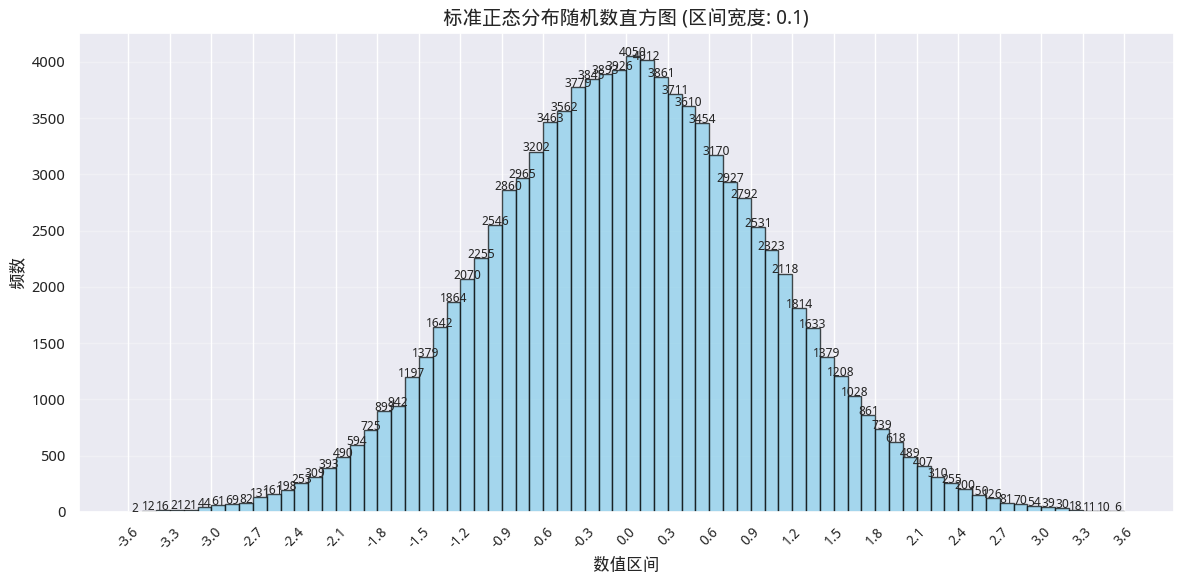

In [13]:
plot_normal_histogram(sample_size=100_000, bin_width=0.1)
plt.show()

In [21]:
import pandas as pd

# 创建数据
data = {
    '序号': [1, 2, 3, 4, 5, 6, 7, 8],
    '结果1': ['H', 'H', 'H', 'H', 'T', 'T', 'T', 'T'],
    '结果2': ['H', 'H', 'T', 'T', 'H', 'H', 'T', 'T'],
    '结果3': ['H', 'T', 'H', 'T', 'H', 'T', 'H', 'T']
}

# 创建DataFrame
df = pd.DataFrame(data)

# 定义高亮函数：有且仅有两个H的行显示为红色
def highlight_two_h(row):
    # 计算每行H的数量（跳过序号列）
    h_count = sum(1 for value in row[1:] if value == 'H')
    return ['color: red' if h_count == 2 else '' for _ in row]

# 应用样式：表头黑底白字，表格宽度加大一倍，符合条件的行红色显示
styled_df = df.style \
    .apply(highlight_two_h, axis=1) \
    .set_table_styles([
        {
            'selector': 'th',  # 表头样式
            'props': [
                ('background-color', 'black'),
                ('color', 'white'),
                ('font-weight', 'bold'),
                ('padding', '10px 20px')  # 增加表头内边距
            ]
        },
        {
            'selector': 'table',  # 表格整体样式
            'props': [
                ('width', '100%'),  # 表格宽度占容器100%
                ('min-width', '800px')  # 最小宽度设置，确保表格足够宽
            ]
        },
        {
            'selector': 'td',  # 单元格样式
            'props': [
                ('padding', '0px 60px'),  # 增加单元格内边距
                ('text-align', 'center')  # 内容居中显示
            ]
        }
    ])

# 显示表格
styled_df
    

,序号,结果1,结果2,结果3
0,1,H,H,H
1,2,H,H,T
2,3,H,T,H
3,4,H,T,T
4,5,T,H,H
5,6,T,H,T
6,7,T,T,H
7,8,T,T,T
